# Hello Image Segmentation

A very basic introduction to using segmentation models with OpenVINO™.

In this tutorial, a pre-trained [road-segmentation-adas-0001](https://docs.openvino.ai/latest/omz_models_model_road_segmentation_adas_0001.html) model from the [Open Model Zoo](https://github.com/openvinotoolkit/open_model_zoo/) is used. ADAS stands for Advanced Driver Assistance Services. The model recognizes four classes: background, road, curb and mark.

## Imports

In [2]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import sys
from openvino.runtime import Core

sys.path.append("../utils")
from notebook_utils import segmentation_map_to_image

## Load the Model

In [3]:
ie = Core()

model = ie.read_model(model="model/semantic-segmentation-adas-0001.xml")
icnet = False
compiled_model = ie.compile_model(model=model, device_name="CPU")

input_layer_ir = compiled_model.input(0)
output_layer_ir = compiled_model.output(0)

## Load an Image
A sample image from the [Mapillary Vistas](https://www.mapillary.com/dataset/vistas) dataset is provided. 

{1, 3, 1024, 2048}
(1024, 2048, 3)
(1, 3, 1024, 2048)


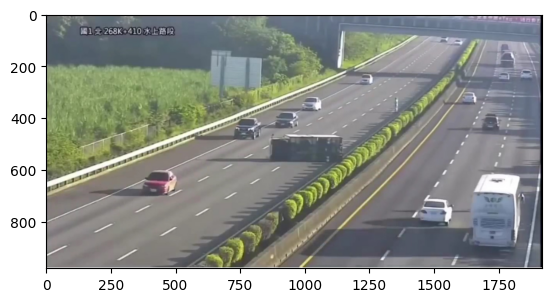

In [44]:
# The segmentation network expects images in BGR format.
image = cv2.imread("data/some3.jpg")

rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_h, image_w, _ = image.shape

# N,C,H,W = batch size, number of channels, height, width.
if(icnet):
    N, H, W, C = input_layer_ir.shape
else:
    N, C, H, W = input_layer_ir.shape
print(input_layer_ir.shape)
# OpenCV resize expects the destination size as (width, height).
resized_image = cv2.resize(image, (W, H))
print(resized_image.shape)
# Reshape to the network input shape.
input_image = np.expand_dims(
    resized_image.transpose(2, 0, 1), 0
)  
print(input_image.shape)
plt.imshow(rgb_image)

## Do Inference

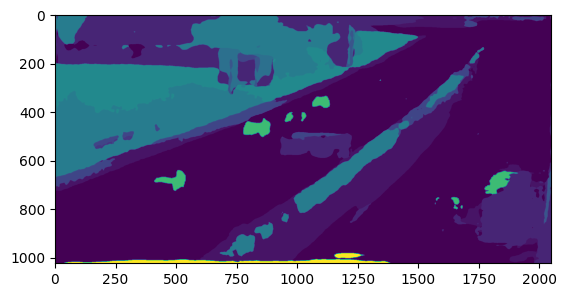

In [45]:
# Run the inference.
result = compiled_model([input_image])[output_layer_ir]

# Prepare data for visualization.
#segmentation_mask = np.argmax(result, axis=0)
def connected_components(result):
    bit_masks = np.zeros((20,1024,2048),dtype=np.uint8)
    for y in range(1024):
        for x in range(2048):
            
            classIndexFromDetections = result[0][0][y][x]
            bit_masks[classIndexFromDetections][y][x] = 255
                #// Set the color for the blank opencv mat
            #blankMat.at<cv::Vec3b>(cv::Point(x,y)) = colors.at(classIndexFromDetections);
            
    component_list = {}
    for i in range(13,14):
        num_labels,labels = cv2.connectedComponents(bit_masks[i])
        components = {}
        con_set = set()
        all_locs = np.transpose(np.nonzero(bit_masks[i]))
        
        for loc in all_locs:
            if bit_masks[i][loc[0]][loc[1]]:
                if labels[loc[0]][loc[1]] not in con_set:
                    con_set.add(labels[loc[0]][loc[1]])
                    components[labels[loc[0]][loc[1]]] = np.array([[loc[1],loc[0]]])
                else:
                    components[labels[loc[0]][loc[1]]] = np.append(components[labels[loc[0]][loc[1]]],np.array([[loc[1],loc[0]]]), axis=0)

        component_list[i] = list(components.values())
    return component_list
def pcas(component_list,im):
    pca_list = []
    
    for i in range(13,14):
        pca = []
        for component in component_list[i]:

            if len(component) == 1 or len(component) == 0:
                continue
            #indexes_to_sample = np.random.uniform(0,len(component),(int(len(component)/8),))
            mean = np.empty((0))
            mean, eigenvectors, eigenvalues = cv2.PCACompute2(component.astype(np.float32), mean=None)
            if len(eigenvalues) < 2:
                print("???")
            mean_0 = np.mean(component[:,0])
            mean_1 = np.mean(component[:,1])
            cntr = (int(mean[0,0]),int(mean[0,1]))
            cv2.circle(im, cntr, 3, (255, 0, 255), 2)
            p1 = (int(cntr[0] + 0.02 * eigenvectors[0,0] * eigenvalues[0,0]), int(cntr[1] + 0.02 * eigenvectors[0,1] * eigenvalues[0,0]))
            p2 = (int(cntr[0] - 0.02 * eigenvectors[1,0] * eigenvalues[1,0]), int(cntr[1] - 0.02 * eigenvectors[1,1] * eigenvalues[1,0]))
            cv2.line(im,cntr,p1,(255,255,0),2)
            cv2.line(im,cntr,p2,(0,255,0),2)
            pca.append((cntr,p1,p2))
        pca_list.append(pca)
    return pca_list
component_list = connected_components(result=result)
pca_list = pcas(component_list,resized_image)
cv2.imwrite("some2.png",resized_image)
plt.imshow(result[0][0])


## Prepare Data for Visualization

In [7]:
# Define colormap, each color represents a class.
colormap = np.array([[68, 1, 84], [48, 103, 141], [53, 183, 120], [199, 216, 52],[0, 1, 84], [0, 103, 141], [0, 183, 120], [0, 216, 52]])

# Define the transparency of the segmentation mask on the photo.
alpha = 0.3

# Use function from notebook_utils.py to transform mask to an RGB image.
mask = segmentation_map_to_image(segmentation_mask, colormap)
resized_mask = cv2.resize(mask, (image_w, image_h))

# Create an image with mask.
image_with_mask = cv2.addWeighted(resized_mask, alpha, rgb_image, 1 - alpha, 0)

## Visualize data

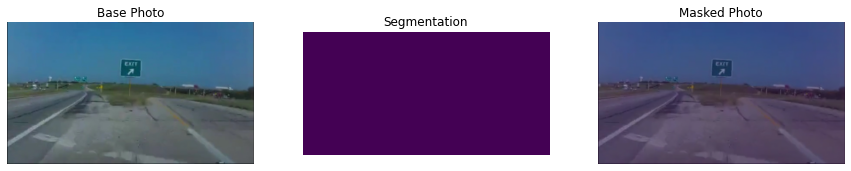

In [8]:
# Define titles with images.
data = {"Base Photo": rgb_image, "Segmentation": mask, "Masked Photo": image_with_mask}

# Create a subplot to visualize images.
fig, axs = plt.subplots(1, len(data.items()), figsize=(15, 10))

# Fill the subplot.
for ax, (name, image) in zip(axs, data.items()):
    ax.axis('off')
    ax.set_title(name)
    ax.imshow(image)

# Display an image.
plt.show(fig)